# MNIST CNN inference

In [44]:
# Cell 1: Import necessary libraries and setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import random

# Enable inline plotting
%matplotlib inline

In [45]:
# Cell 2: Check device availability (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [46]:
# Cell 3: Data preprocessing and dataset loading
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

print(f'Train Size: {len(train_dataset)}, Test Size: {len(test_dataset)}')

Train Size: 60000, Test Size: 10000


In [47]:
# Cell 4: Create data loaders for training and testing
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


Input Size: torch.Size([64, 1, 28, 28])


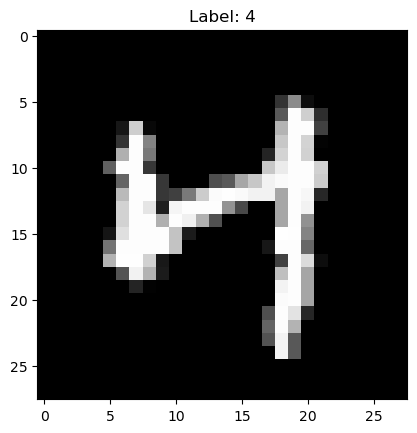

In [48]:
# Cell 5: Display sample image from training data
for example_data, example_labels in train_loader:
    example_image = example_data[0]
    print("Input Size:", example_data.size())
    
    example_image_numpy = example_image.permute(1, 2, 0).numpy()
    plt.imshow(example_image_numpy.squeeze(), cmap='gray')
    plt.title(f"Label: {example_labels[0]}")
    plt.show()
    break

In [49]:
# Cell 6: Define SimpleCNN model architecture (Fully Convolutional)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Feature extraction layers (moderate channel progression)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(24)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=72, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(72)
        
        # Pooling and activation
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # Fully convolutional classification layers (1x1 convolutions)
        self.conv1x1_1 = nn.Conv2d(in_channels=72, out_channels=128, kernel_size=1)
        self.bn_fc1 = nn.BatchNorm2d(128)
        
        self.conv1x1_2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1)
        self.bn_fc2 = nn.BatchNorm2d(64)
        
        self.conv1x1_3 = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout2d(0.4)
        
        # Global Average Pooling for final classification
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x):
        # Feature extraction with convolution + BatchNorm + ReLU + MaxPool
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # (batch, 24, 14, 14)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))  # (batch, 48, 7, 7)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))  # (batch, 72, 3, 3)
        
        # Fully convolutional classification using 1x1 convolutions
        x = self.relu(self.bn_fc1(self.conv1x1_1(x)))      # (batch, 128, 3, 3)
        x = self.dropout(x)
        x = self.relu(self.bn_fc2(self.conv1x1_2(x)))      # (batch, 64, 3, 3)
        x = self.conv1x1_3(x)                              # (batch, 10, 3, 3)
        
        # Global Average Pooling to get final classification scores
        x = self.global_avg_pool(x)                        # (batch, 10, 1, 1)
        x = x.view(x.size(0), -1)                         # (batch, 10)
        
        return x

In [50]:
# Cell 7: Initialize model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")


Model created with 60,754 parameters


In [51]:
# Cell 8: Real-time training visualization function
def plot_training_progress(train_losses, epoch_losses, current_epoch, total_epochs):
    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    if train_losses:
        ax1.plot(train_losses, alpha=0.7, linewidth=0.8, color='blue')
        ax1.set_title(f'Training Loss per Batch (Epoch {current_epoch}/{total_epochs})')
        ax1.set_xlabel('Batch Number')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, max(1.0, max(train_losses) if train_losses else 1.0))
    
    if epoch_losses:
        epochs_range = range(1, len(epoch_losses) + 1)
        ax2.plot(epochs_range, epoch_losses, 'r-', linewidth=2, marker='o', markersize=4)
        ax2.set_title('Average Training Loss per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Average Loss')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, total_epochs)
        if epoch_losses:
            ax2.set_ylim(0, max(epoch_losses) * 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    if train_losses:
        print(f"Current Batch Loss: {train_losses[-1]:.4f}")
    if epoch_losses:
        print(f"Last Epoch Average Loss: {epoch_losses[-1]:.4f}")
        print(f"Best Epoch Loss: {min(epoch_losses):.4f}")


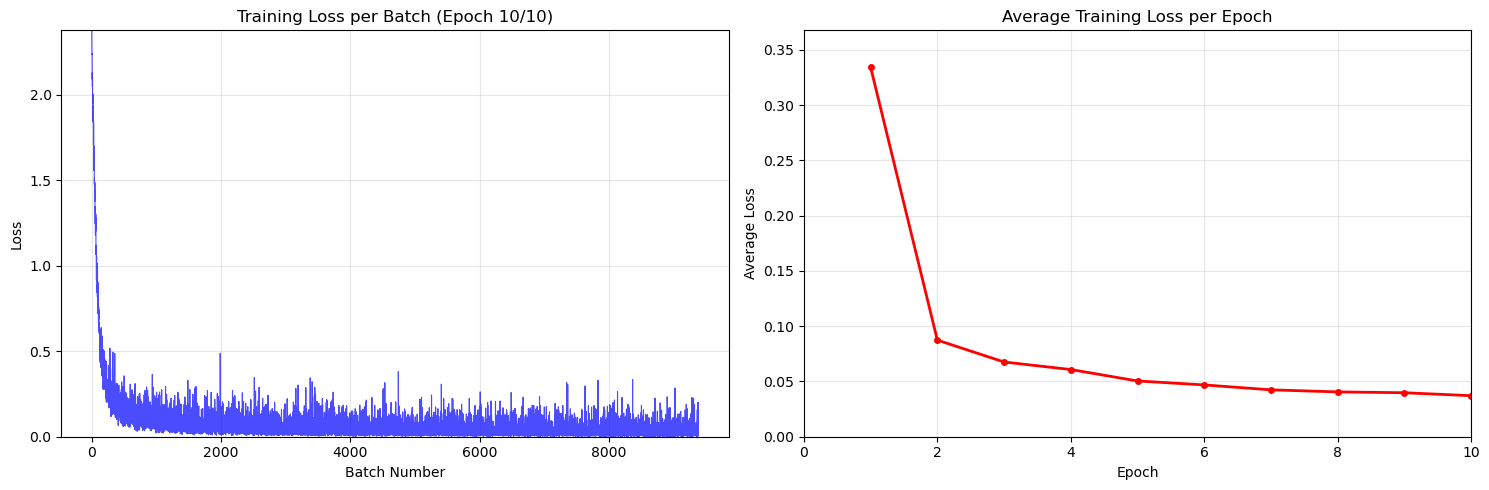

Current Batch Loss: 0.1996
Last Epoch Average Loss: 0.0371
Best Epoch Loss: 0.0371
Epoch 10 completed. Average Loss: 0.0371
Training Finished!


In [52]:
# Cell 9: Training loop with real-time visualization
num_epochs = 10 
train_losses = []
epoch_losses = []
running_loss = 0.0
plot_interval = 50

print("Starting Training...")

for epoch in range(num_epochs):
    epoch_loss = 0.0
    batch_count = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        train_losses.append(current_loss)
        epoch_loss += current_loss
        batch_count += 1
        running_loss += current_loss
        
        if i % 100 == 99:
            avg_loss = running_loss / 100
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}")
            running_loss = 0.0
        
        # Update plot every 50 batches
        if i % plot_interval == 0:
            plot_training_progress(train_losses, epoch_losses, epoch + 1, num_epochs)
    
    # End of epoch
    avg_epoch_loss = epoch_loss / batch_count if batch_count > 0 else 0
    epoch_losses.append(avg_epoch_loss)
    plot_training_progress(train_losses, epoch_losses, epoch + 1, num_epochs)
    
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_epoch_loss:.4f}")

print('Training Finished!')

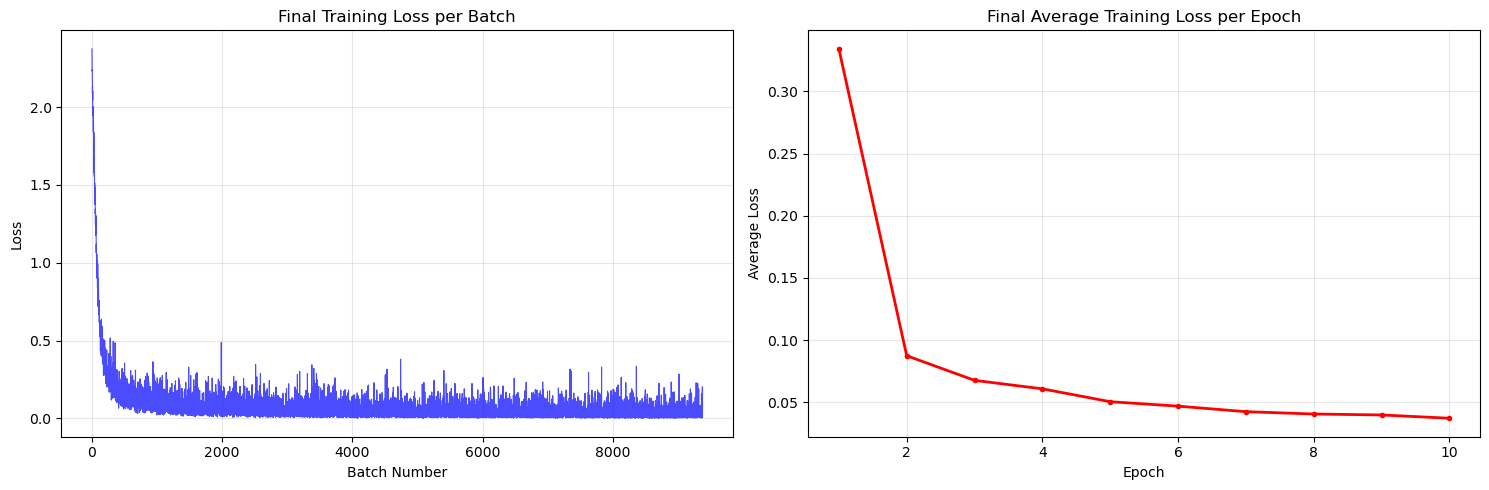

Initial Loss: 2.3753
Final Loss: 0.1996
Best Epoch Loss: 0.0371
Loss Reduction: 2.1757


In [53]:
# Cell 10: Final training visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, alpha=0.7, linewidth=0.8, color='blue')
plt.title('Final Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_losses, 'r-', linewidth=2, marker='o', markersize=3)
plt.title('Final Average Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial Loss: {train_losses[0]:.4f}")
print(f"Final Loss: {train_losses[-1]:.4f}")
print(f"Best Epoch Loss: {min(epoch_losses):.4f}")
print(f"Loss Reduction: {train_losses[0] - train_losses[-1]:.4f}")


In [54]:
# Cell 11: Model evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_targets)

print("Evaluating model...")
predictions, true_labels = evaluate_model(model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision_macro = precision_score(true_labels, predictions, average='macro')
recall_macro = recall_score(true_labels, predictions, average='macro')
f1_macro = f1_score(true_labels, predictions, average='macro')

print("Overall Performance Metrics:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")

Evaluating model...
Overall Performance Metrics:
Accuracy: 0.9891 (98.91%)
Precision (Macro): 0.9893
Recall (Macro): 0.9889
F1-Score (Macro): 0.9891


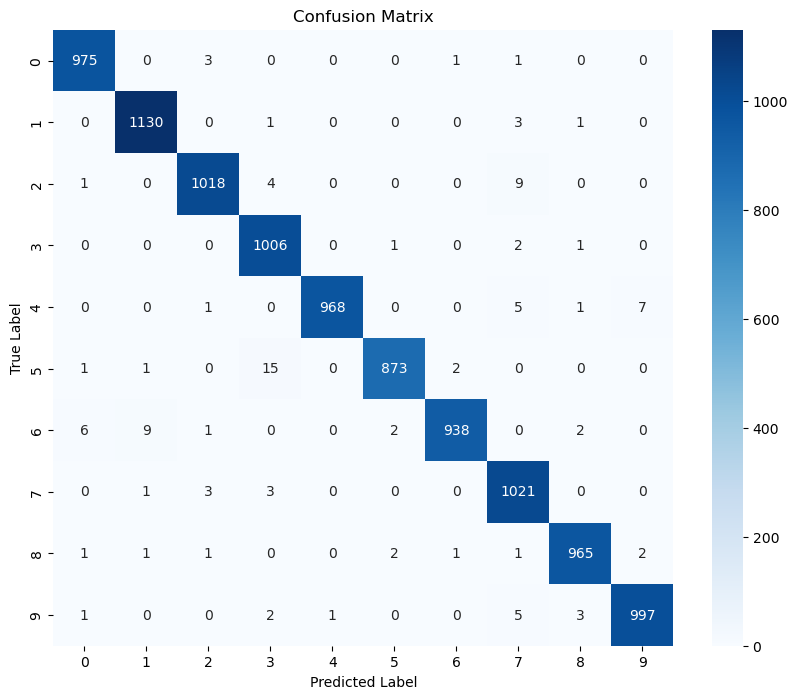

In [55]:
# Cell 12: Confusion matrix visualization
mnist_classes = [str(i) for i in range(10)]
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=mnist_classes,
            yticklabels=mnist_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

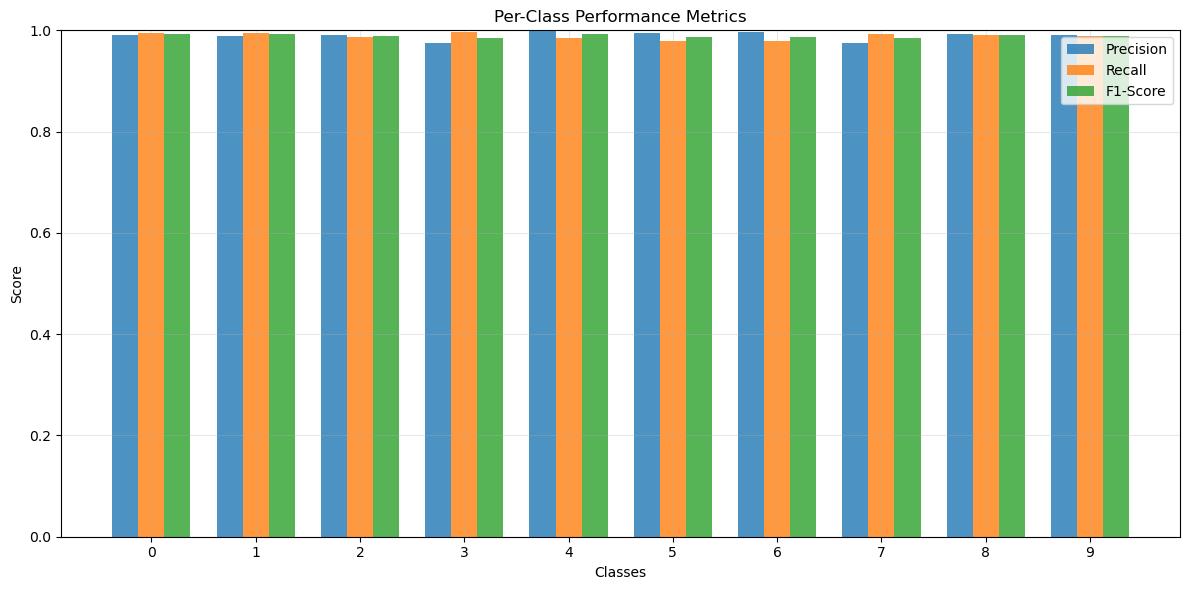

In [56]:
# Cell 13: Per-class performance visualization
precision_per_class = precision_score(true_labels, predictions, average=None)
recall_per_class = recall_score(true_labels, predictions, average=None)
f1_per_class = f1_score(true_labels, predictions, average=None)

x = np.arange(len(mnist_classes))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8)
plt.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Per-Class Performance Metrics')
plt.xticks(x, mnist_classes)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

In [57]:
# Cell 14: Classification report
print("Detailed Classification Report:")
report = classification_report(true_labels, predictions, target_names=mnist_classes)
print(report)


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [58]:
# Cell 15: Generate submission file
print("Generating submission...")
submission_predictions = []

model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        submission_predictions.extend(predicted.cpu().tolist())

submission = pd.DataFrame({
    "ImageId": range(1, len(submission_predictions) + 1),
    "Label": submission_predictions
})

submission.to_csv('submission.csv', index=False)
print(f"Submission saved! Predictions: {len(submission_predictions)}")
print(f"Final Test Accuracy: {accuracy*100:.2f}%")


Generating submission...
Submission saved! Predictions: 10000
Final Test Accuracy: 98.91%


Testing model on random samples from test dataset:


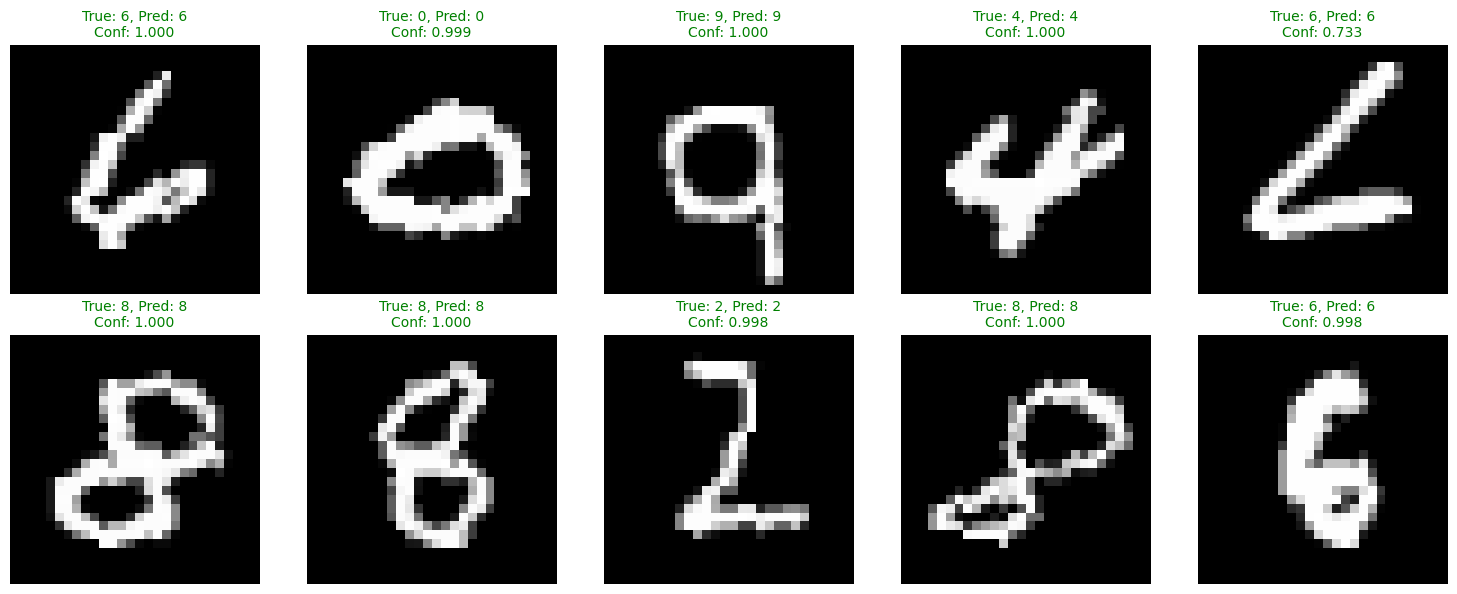

Sample accuracy: 10/10 = 100.0%


In [59]:
# Cell 16: Random test samples inference
def test_random_samples(model, test_dataset, device, num_samples=10):
    """Test model on random samples from test dataset"""
    model.eval()
    
    # Get random indices
    random_indices = random.sample(range(len(test_dataset)), num_samples)
    
    plt.figure(figsize=(15, 6))
    
    for i, idx in enumerate(random_indices):
        # Get image and label
        image, true_label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        
        # Predict
        with torch.no_grad():
            output = model(image)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            predicted_class = predicted.item()
            confidence_score = confidence.item()
        
        # Display
        plt.subplot(2, 5, i + 1)
        img_numpy = image.squeeze().cpu().numpy()
        plt.imshow(img_numpy, cmap='gray')
        
        # Color code: green for correct, red for incorrect
        color = 'green' if predicted_class == true_label else 'red'
        plt.title(f'True: {true_label}, Pred: {predicted_class}\nConf: {confidence_score:.3f}', 
                 color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy for this sample
    correct = sum(1 for i, idx in enumerate(random_indices) 
                  if test_dataset[idx][1] == model(test_dataset[idx][0].unsqueeze(0).to(device)).argmax().item())
    print(f"Sample accuracy: {correct}/{num_samples} = {correct/num_samples*100:.1f}%")

# Run random test
print("Testing model on random samples from test dataset:")
test_random_samples(model, test_dataset, device, num_samples=10)



In [60]:
# Cell 17: Model summary and available functions
print("\n" + "="*50)
print("MODEL TRAINING COMPLETED")
print("="*50)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Optimizer: Adam")
print(f"Training Epochs: {num_epochs}")
print(f"Device Used: {device}")
print("="*50)
print("\nTo test random samples again, run:")
print("test_random_samples(model, test_dataset, device, num_samples=10)")
print("="*50)


MODEL TRAINING COMPLETED
Final Test Accuracy: 98.91%
Total Parameters: 60,754
Optimizer: Adam
Training Epochs: 10
Device Used: cpu

To test random samples again, run:
test_random_samples(model, test_dataset, device, num_samples=10)
